# Linear Regression Assignment 

## Introduction
For this assignment, we are going to explore data from activity trackers. Activity trackers are applications that track your activity using your smartphone, a smartwatch, wrist band or a clip-on device. Popular applications include Steps (iPhone), Apple Watch, Fitbit and Jawbone. For a study in France, over 900 volunteers received a Fitbit Zip (a clip-on activity tracker) and recorded their daily steps, distance and calories. 

In [1]:
import seaborn as sns #this is the plotting library I'll be using 
import pandas as pd #"as pd" means that we can use the abbreviation in commands
import math
import matplotlib.pyplot as plt #we need Matplotlib for setting the labels in the Seaborn graphs
import numpy as np
from sklearn.linear_model import LinearRegression #remember, this is linear regression model from sk-learn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

## Read & Merge files
We will merge the csv files on the 'id'-row, since both datasets use it. 
Also, by using `sep=None`, pandas will automatically recognize the seperator. 


In [2]:
df1= pd.read_csv('survey.csv', encoding='UTF-8')
df2 = pd.read_csv('steps.csv', encoding='UTF-8', sep=None, engine='python')

df = pd.merge(df1, df2, on = 'id')


df['weight'].value_counts() #Get all the values. This may be less useful when there are many values.

72.0     40
65.0     35
73.0     32
80.0     31
55.0     31
         ..
128.0     1
116.0     1
102.0     1
101.0     1
105.0     1
Name: weight, Length: 72, dtype: int64

## Data Cleaning

We will remove unlikely values, ex. `weight > 200kg`  or  `weight < 30kg` if these are true, the entire row will be set to NaN.

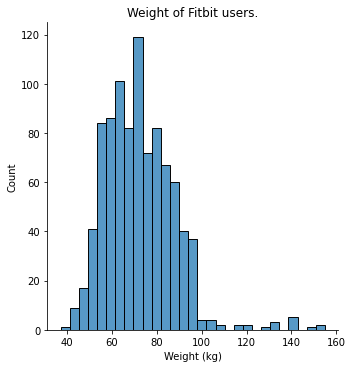

In [3]:
df['weight'] = df['weight'].apply(pd.to_numeric, errors='coerce')

def above_200(weight):
    if(weight > 200.0): 
        return float('NaN')
    else: 
        return weight
    
def below_30(weight):
    if(weight < 30.0):
        return float('NaN')
    else: 
        return weight
    
df['weight'] = df['weight'].apply(above_200)
df['weight'] = df['weight'].apply(below_30)


sns.displot(df['weight'].dropna(), kde=False) #Selecting the rating column. I need to drop the NA's for the plot
plt.title('Weight of Fitbit users.')
plt.xlabel('Weight (kg)')
plt.ylabel('Count')
plt.show()

## Feature Engineering
I want to calculate a bmi score for each participant in order to see how healthy they really are. There are however a couple of caviats. We don't have an accurate age, so we have to generalize it. Also, bmi scores are not representitive if the participant is pregnant, very muscular or is of Asian descent. 

To combat the the first issue I will take the middle of the age categories. 

The formula to calculate bmi is `weight / height²`. Weight in kg, Height in m.
The value this outputs can than be used in combination with the participant's age in order to give them a health score.

In [4]:
def average_age(age):
    if age == '<25':
        return 20
    elif age == '25-34':
        return 30
    elif age == '35-44':
        return 40
    elif age == '45-54':
        return 50
    elif age == '55-64':
        return 60
    elif age == '65-74':
        return 70
    elif age == '75-84':
        return 80

def bmi_value(bmi_score):
    if bmi_score < 18.5:
        return 'underweight'
    elif bmi_score < 25.0:
        return 'healthy'
    elif bmi_score < 30.0:
        return 'overweight'
    elif bmi_score <= 35.0:
        return 'obese'
    elif bmi_score > 35.0:
        return 'extreme obese'


df['ave_age'] = df['age'].apply(average_age)
df['bmi_score'] = (df['weight'] / ((df['height'] / 100) * (df['height']) / 100))
df['bmi_value'] = df['bmi_score'].apply(bmi_value)

## Exploratory data analysis


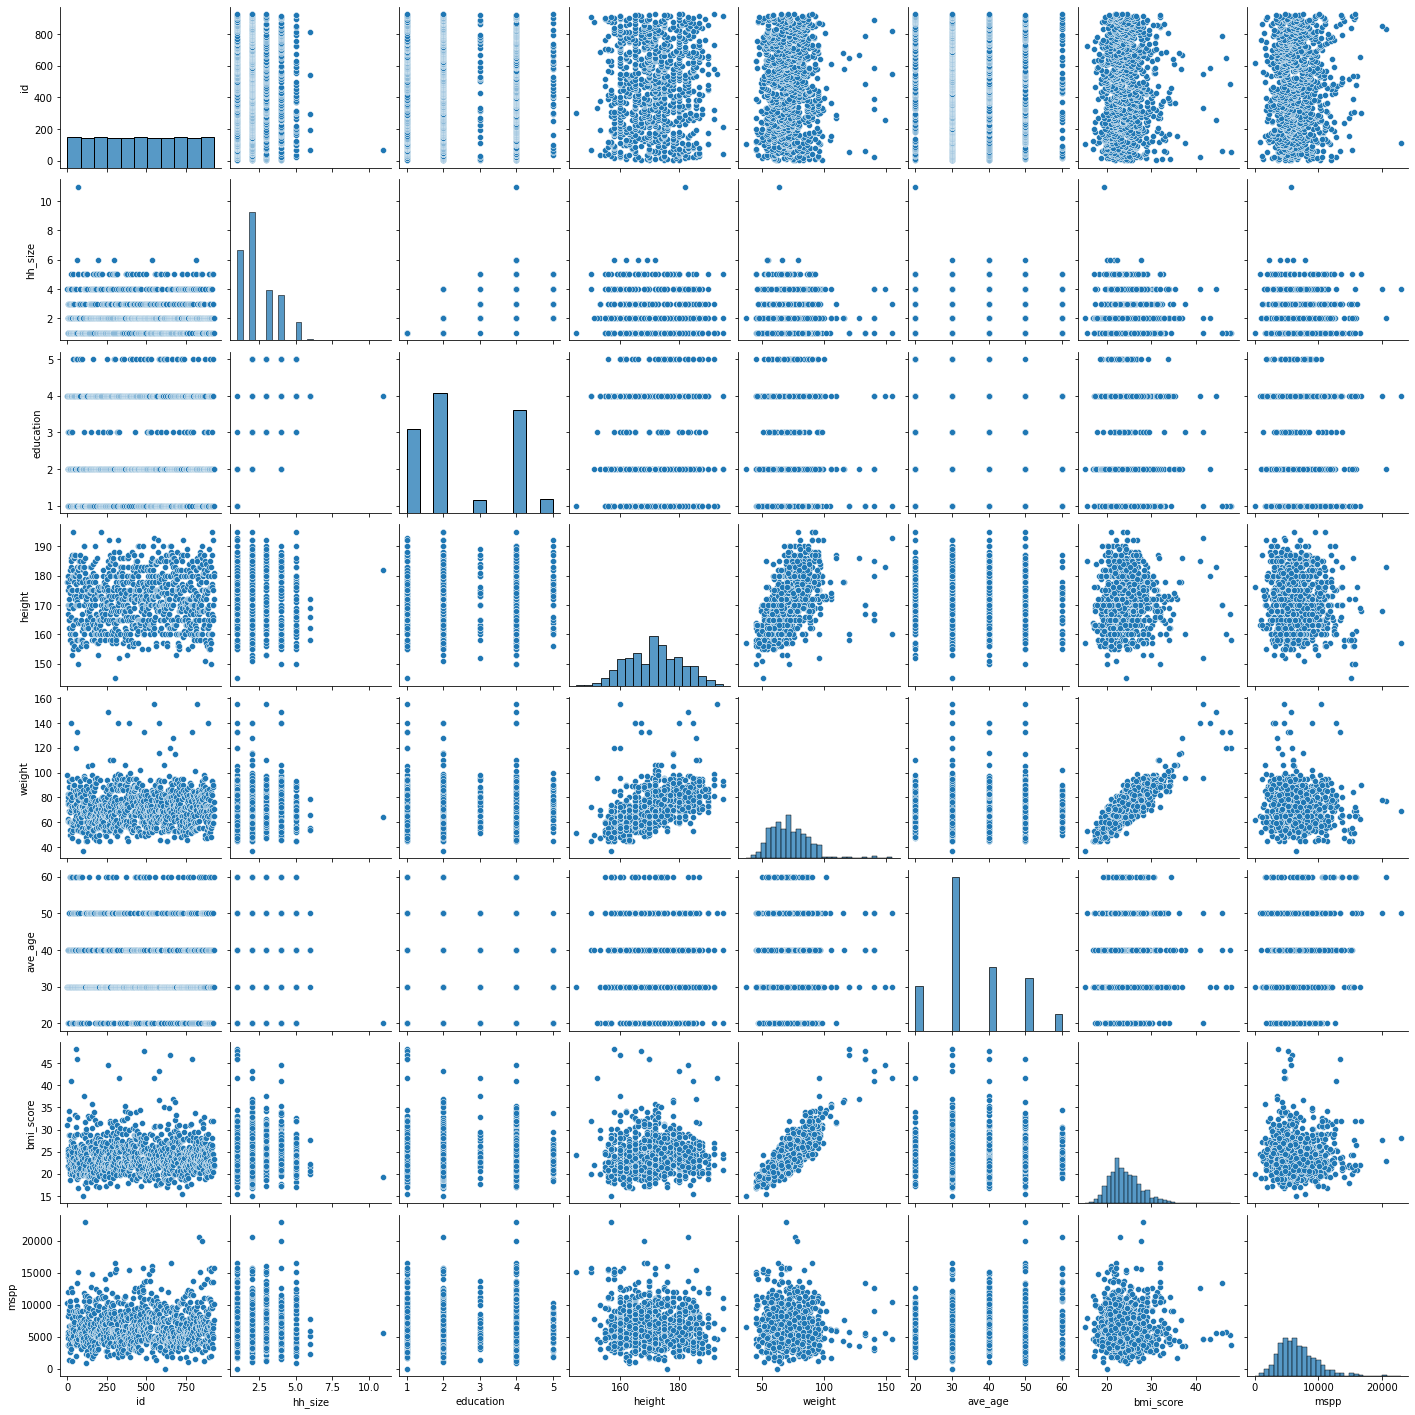

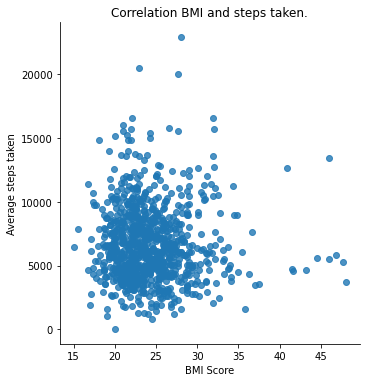

In [5]:
df['mspp'] = df.iloc[:, 10:337].mean(axis = 1)
df_sub = df
df_sub = df_sub.drop(df_sub.iloc[:, 9:337], axis=1)


def rem_mspp(mspp):
    if mspp > 25000.0:
        return float('NaN')
    else:
        return mspp

def rem_bmi(bmi_score):
    if bmi_score > 50.0:
        return float('NaN')
    else:
        return bmi_score


df_sub['mspp'] = df_sub['mspp'].apply(rem_mspp)
df_sub['bmi_score'] = df_sub['bmi_score'].apply(rem_bmi)
sns.pairplot(df_sub)
# plt.show()

sns.lmplot(x="bmi_score", y="mspp", fit_reg=False, data=df_sub)
plt.xlabel('BMI Score') #use matplotlib to refine Seaborn plot
plt.ylabel('Average steps taken')
plt.title('Correlation BMI and steps taken.')
plt.show()

In [6]:
from scipy.stats.stats import pearsonr #We will need the correlation function from the scientific package scipy
df_sub["mspp"] = np.nan_to_num(df_sub["mspp"])
df_sub["bmi_score"] = np.nan_to_num(df_sub["bmi_score"], nan=20.0, posinf=20.0)
df_sub["ave_age"] = np.nan_to_num(df_sub["ave_age"])


print(pearsonr(df_sub['mspp'],df_sub['bmi_score']))
print(pearsonr(df_sub['mspp'],df_sub['ave_age']))

(-0.03714012381047614, 0.258106224873923)
(0.1726199221795029, 1.196203017487297e-07)


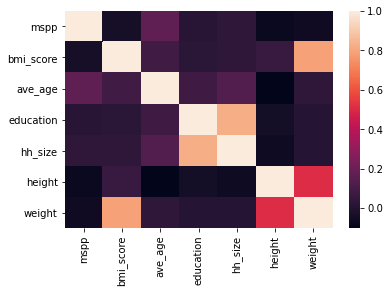

In [7]:
corr = df_sub[['mspp', 'bmi_score', 'ave_age', 'education','hh_size', 'height', 'weight']].corr() #I'm leaving out the corrected variables (divided by 1 million)
corr

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns) #the last two arguments set the column names
plt.show()

## Linear Regression

In [8]:
x = df_sub[['bmi_score']] #get the mean steps per person
y = df_sub['mspp'] #get the bmi
lm = LinearRegression() #create a new (empty model)
lm.fit(x, y) #this "fits" the model

b0 = lm.intercept_ #gets the intercept
b1 = lm.coef_[0] #lm.coef_ gets a list of coefficients (excluding the intercept). [0] gets the actual number from the list

print(f"The regression line is equal to y = {b0:.3f} + {b1:.3f}X") #.0f formats to 3 decimals.
lm.predict([[30]]) 

The regression line is equal to y = 7291.476 + -26.545X


array([6495.1183423])

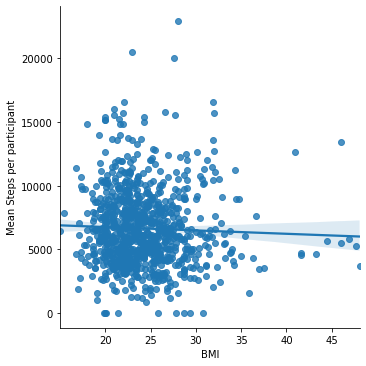

In [9]:
sns.lmplot(x='bmi_score', y='mspp', data=df_sub)
plt.title('')
plt.xlabel("BMI")
plt.ylabel("Mean Steps per participant")
plt.show()

## Formula

`y = b1 + (b2*x) + e`

The above code splits the data into test and train data, randomly. A percentage of 30% for the test set is typical. Now we will fit the model with the train data only. 

In [10]:
df_sub['mspp_p'] = lm.predict(x) #generate the predictions and add them to the dataframe
df_sub['resid'] = df_sub['mspp'] - df_sub['mspp_p'] #get the residuals by subtracting the prediction from the actual views
df_sub.head(10)

,id,city,gender,age,hh_size,education,education_1,height,weight,ave_age,bmi_score,bmi_value,mspp,mspp_p,resid
0,1,Bordeaux,Male,25-34,4,4,Master or doctorate,178.0,98.0,30.0,30.930438,obese,10205.521212,6470.419639,3735.101573
1,2,Lille,Male,35-44,1,3,Bachelor,180.0,77.0,40.0,23.765432,healthy,5687.423313,6660.616451,-973.193139
2,3,Montpellier,Male,25-34,2,2,Master or doctorate,180.0,83.0,30.0,25.617284,overweight,8301.729730,6611.458597,1690.271132
3,4,Lyon,Male,<25,1,1,Bachelor,178.0,80.0,20.0,25.249337,overweight,3633.200000,6621.225832,-2988.025832
4,5,Montpellier,Female,25-34,3,4,Bachelor,167.0,61.0,30.0,21.872423,healthy,5312.129630,6710.866840,-1398.737210
5,6,Lille,Male,35-44,1,1,Vocational,170.0,63.0,40.0,21.799308,healthy,11908.509804,6712.807691,5195.702113
6,7,Montpellier,Male,25-34,2,2,Master or doctorate,175.0,75.0,30.0,24.489796,healthy,4715.400000,6641.388039,-1925.988039
7,8,Bordeaux,Female,25-34,3,4,Master or doctorate,165.0,88.0,30.0,32.323232,obese,3594.051724,6433.447580,-2839.395856
8,9,Lille,Female,35-44,4,4,Vocational,172.0,69.0,40.0,23.323418,healthy,8626.707965,6672.349821,1954.358144
9,10,Lille,Female,25-34,2,2,Master or doctorate,165.0,93.0,30.0,34.159780,obese,3787.043478,6384.695989,-2597.652511


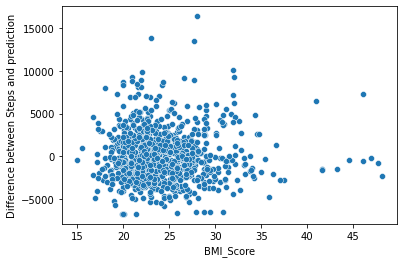

In [11]:
sns.scatterplot(x='bmi_score',y='resid',data=df_sub)
plt.xlabel('BMI_Score')
plt.ylabel('Difference between Steps and prediction')
plt.show()

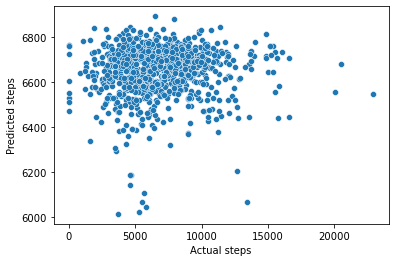

In [12]:
sns.scatterplot(x='mspp',y='mspp_p',data=df_sub)
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('Actual steps')
plt.ylabel('Predicted steps')
plt.show()


In [13]:
r2_score(df_sub['mspp'], df_sub['mspp_p']) #this gives the model fit (R2) for the Y and predicted Y

0.0013793887966575546

In [14]:
math.sqrt(mean_squared_error(df_sub['mspp'], df_sub['mspp_p'])) #this gives the model fit (R2) for the Y and predicted Y #this gives the model fit (R2) for the Y and predicted Y

3000.4848215996235